In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import xarray as xr
import numpy as np
import pandas as pd

In [4]:
xr.set_options(keep_attrs=True)

In [5]:
import ecephys_analyses as ea 
from ecephys import utils
from ecephys.signal.xarray_utils import filter_dataset_by_hypnogram

In [6]:
def ds2df(ds):
    s = ds.to_dataframe().stack()
    s.index.names = s.index.names[:-1] + ['region']
    return s.to_frame(name='power')

In [7]:
subject = "Segundo"
experiment = "sleep-homeostasis"
norm_condition = "light-period-circadian-match"
bsl_condition = "recovery-sleep-circadian-match"
rec_condition = "recovery-sleep"
states = ["N1", "N2"]
duration = '02:00:00'
light_period_start = '09:00:00'
light_period_end = '21:00:00'
f_range = (0.5, 4)

In [8]:
norm_hyp = ea.load_hypnogram(subject, experiment, norm_condition)
norm_hyp = norm_hyp.keep_states(states).keep_between(light_period_start, light_period_end)

norm_pow = ea.load_power(subject, experiment, norm_condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim="frequency")
norm_pow = filter_dataset_by_hypnogram(norm_pow, norm_hyp).swap_dims({'time': 'datetime'}).drop_vars(['time', 'timedelta'])

In [9]:
rec_hyp = ea.load_hypnogram(subject, experiment, rec_condition)
rec_hyp = rec_hyp.keep_states(states).keep_first(duration)

rec_pow = ea.load_power(subject, experiment, rec_condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim='frequency')
rec_pow = filter_dataset_by_hypnogram(rec_pow, rec_hyp).swap_dims({'time': 'datetime'}).drop_vars(['time', 'timedelta'])
rec_pow = rec_pow / norm_pow.mean(dim="datetime") * 100

In [10]:
bsl_hyp = ea.load_hypnogram(subject, experiment, bsl_condition)
bsl_hyp = bsl_hyp.keep_states(states).keep_between(rec_hyp.start_time.min().strftime("%H:%M:%S"), light_period_end).keep_first(duration)

bsl_pow = ea.load_power(subject, experiment, bsl_condition, "spg.nc").sel(frequency=slice(*f_range)).sum(dim='frequency')
bsl_pow = filter_dataset_by_hypnogram(bsl_pow, bsl_hyp).swap_dims({'time': 'datetime'}).drop_vars(['time', 'timedelta'])
bsl_pow = bsl_pow / norm_pow.mean(dim="datetime") * 100

In [11]:
nrem_pow = pd.concat([ds2df(bsl_pow).assign(condition="baseline"), ds2df(rec_pow).assign(condition="recovery")])

In [12]:
nrem_pow

power condition
datetime            region                           
2020-01-22 15:17:53 mpta_wm_ref   11.042340  baseline
                    sr_wm_ref     35.280193  baseline
2020-01-22 15:17:56 mpta_wm_ref    5.083761  baseline
                    sr_wm_ref     21.049922  baseline
2020-01-22 15:18:14 mpta_wm_ref    4.539901  baseline
...                                     ...       ...
2020-01-23 18:41:38 sr_wm_ref     85.321279  recovery
2020-01-23 18:41:41 mpta_wm_ref  113.484671  recovery
                    sr_wm_ref    110.291088  recovery
2020-01-23 18:41:44 mpta_wm_ref   85.995982  recovery
                    sr_wm_ref    176.382399  recovery

[9436 rows x 2 columns]

In [43]:
def mean_of_differences(df):
    region_differences = df.power.loc[(slice(None), 'mpta_wm_ref')] - df.power.loc[(slice(None), 'sr_wm_ref')]
    conditions = df.condition.loc[(slice(None), 'mpta_wm_ref')]
    return pd.concat([region_differences, conditions], axis=1).groupby(['condition']).mean()

In [44]:
def recovery_minus_baseline(df):
    return df.xs('recovery') - df.xs('baseline')

In [45]:
def shuffle_region_labels(df): 
    permuted = df.reset_index()
    region_labels = permuted.region.values.reshape(-1, 2)
    rng = np.random.default_rng()
    rng.permuted(region_labels, axis=1, out=region_labels)
    permuted.set_index(['datetime', 'region'], inplace=True)
    return permuted

In [46]:
observed = recovery_minus_baseline(mean_of_differences(nrem_pow))

n_permutations = 10000
permutations = list()
for i in range(n_permutations):
    permuted = shuffle_region_labels(nrem_pow)
    permutations.append(recovery_minus_baseline(mean_of_differences((permuted))))
    
df = pd.concat(permutations).to_frame(name='rec_minus_bsl').reset_index(drop=True)

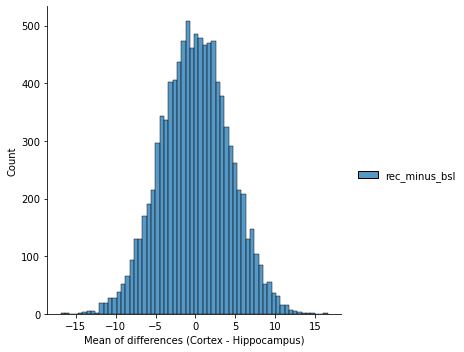

In [50]:
g = sns.displot(data=df, kind='hist')
g.set(xlabel='Mean of differences (Cortex - Hippocampus)')
g.tight_layout()

In [52]:
p = np.sum(df.rec_minus_bsl.values >= observed.power)

In [54]:
print(f"Subject: {subject}")
print('Observed difference, Cortex - Hippocampus:')
print(f'{observed}')
print('')
print('Shuffled differences >= observed:')
print(f"Cortex: {1 + p} / {n_permutations}")

Subject: Segundo
Observed difference, Cortex - Hippocampus:
power    132.650825
dtype: float64

Shuffled differences >= observed:
Cortex: 1 / 10000
